In [30]:
!pip install svgpath2mpl
!pip install svgpathtools

  Using cached svgpath2mpl-1.0.0-py2.py3-none-any.whl (7.8 kB)
  Using cached svgwrite-1.4.1-py3-none-any.whl (66 kB)


In [63]:
import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as patches

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from scipy.special import expit
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.formula import api as smf
from sklearn.metrics import RocCurveDisplay

# Part 1 - Data Visualization

In [35]:
#Load data
bats_df = pd.read_csv('atbats.csv')
pitches_df = pd.read_csv('pitches.csv')

In [36]:
#Merge and drop duplicates
df = pd.merge(bats_df, pitches_df, how='inner', on='ab_id')

df = df.drop_duplicates(subset=['ab_id'], keep='last')

Text(0.5, 33.0, 'Count')

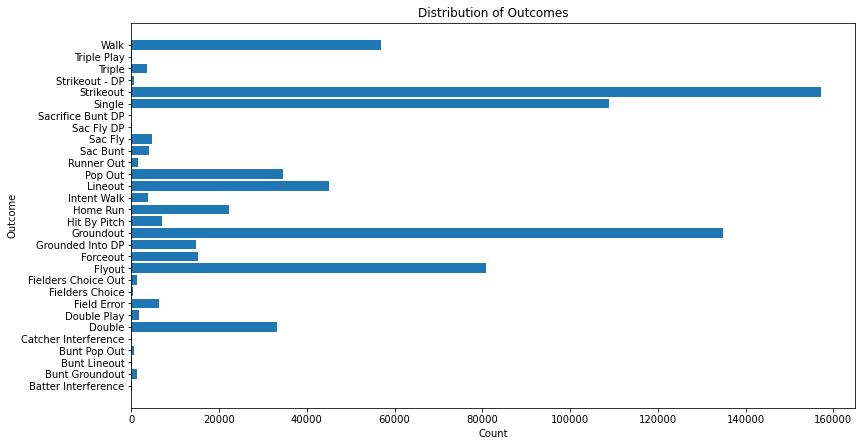

In [37]:
#Horizontal bar graph of event counts
vals, counts = np.unique(df.event.values, return_counts = True)

plt.figure(figsize = (12,6))
plt.barh(vals, counts)
plt.tight_layout(pad=1.5)
plt.title("Distribution of Outcomes")
plt.ylabel("Outcome")
plt.xlabel("Count")

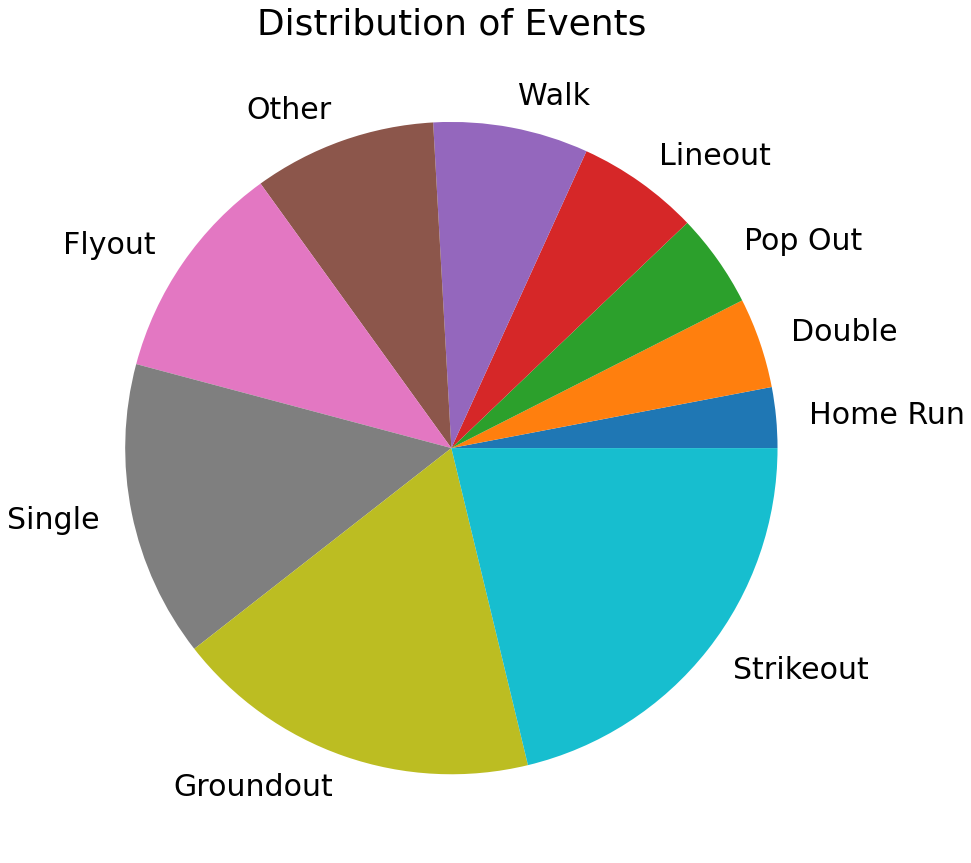

In [38]:
#Pie chart of event distributions
cutoff = .025
test = counts / sum(counts)

rest_pct = sum(counts[test < cutoff])
new_counts = counts[test >= cutoff]
new_labels = vals[test >= cutoff]

new_labels = np.append(new_labels, 'Other')
new_counts = np.append(new_counts, rest_pct)

zipped_lists = zip(new_counts, new_labels)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
final_counts, final_labels = [ list(tuple) for tuple in  tuples]

plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(15,15))
plt.pie(x = final_counts,labels=final_labels)
plt.title("Distribution of Events")

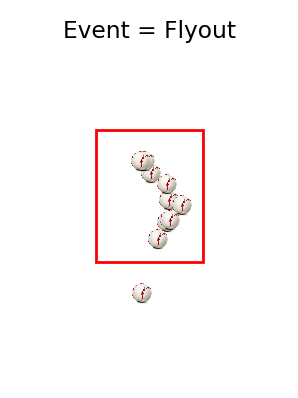

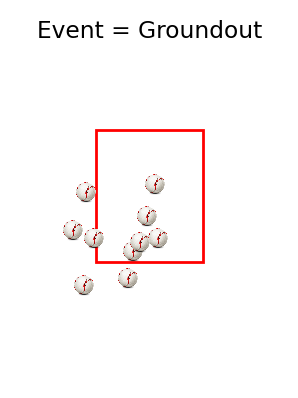

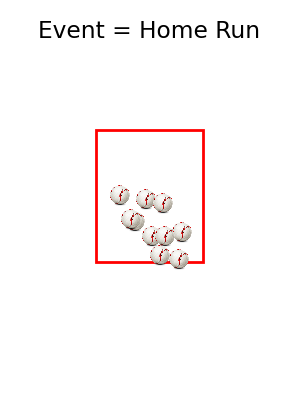

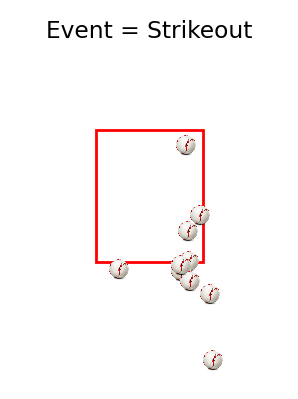

In [54]:
#For select events, plot a sample of the pitch location for pitches resulting in that event
#Most of this code is to plot baseballs instead of points on the graph

plt.rcParams.update({'font.size': 7})

num_vals = 10

event_dict = {10:'flyout', 13:'groundout',15:'homerun',25:'strikeout'}

events_of_interest = [10,13,15,25]
event_names = ['Flyout', 'Groundout', 'Home Run', 'Strikeout']

for i,val in enumerate(event_names):
    #Set parameters
    plt.rcParams["figure.figsize"] = [2,2]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams['figure.dpi'] = 200
    
    #Get dataframe for select event
    event_df = df[df.event == val]

    def getImage(path):
        return OffsetImage(plt.imread(path, format="jpg"), zoom=.015)
    
    paths = ['baseball2.png'] * num_vals
    
    #Get sample from dataframe
    x = event_df.sample(n=10).px.values
    y = event_df.sample(n=10).pz.values
    
    #Plot
    fig, ax = plt.subplots()
    
    rect = patches.Rectangle((-.83, 1.79), 1.66, 2.046, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    for x0, y0, path in zip(x, y, paths):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)
    
    plt.xlim(-2,2)
    plt.ylim(0,5)
    plt.title("Event = {}".format(event_names[i]))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')

    plt.show()

# Part 2 - Data Cleaning

Using data found from this (https://www.kaggle.com/pschale/mlb-pitch-data-20152018) kaggle repository, we begin by cleaning. For a more in depth description of the data and the features found in the data, please refer to our paper.

In [ ]:
#Reading in data
pitch = pd.read_csv("pitches.csv")
atbat = pd.read_csv("atbats.csv")

#Merge the dataframes on at-bat ID number
df = pd.merge(atbat, pitch, how='inner', on='ab_id')
df = df.drop_duplicates(subset=['ab_id'], keep='last')
df.index = df['ab_id']

#Drop all Nan values
df = df.dropna()

# Encodes the results column
results, count = np.unique(df.event, return_counts=True)
dic = dict()
for i,val in enumerate(results):
    dic[val] = i

#List of all events that result in the batter being out
outs = [1, 2, 3, 6, 9, 10, 11, 12, 13, 17, 18, 20, 21, 22, 23, 25, 26, 28]

#List of all events that result in the batter getting on base
ons = [5, 14, 15, 24, 27, 29]

#Change event column to be either 'out' or 'on'
for index, row in df.iterrows():
    if dic[row['event']] in outs:
        df.at[index, 'event'] = 'out'
    elif dic[row['event']] in ons:
        df.at[index, 'event'] = 'on'

#Inverse dictionary to get name of result
inv_dic = {v: k for k, v in dic.items()} 

df1 = df.copy()

#Drop events that are outside of that batter's control
#Examples include Intent Walk or Catcher Interference
for val in [0,4,7,8,16,19]:
    df1 = df1.drop(df1.loc[df1['event']==inv_dic[val]].index)

#One hot encode and drop first
#This is for categorical features
p_throws = pd.get_dummies(df1.p_throws, prefix='p_throws', dtype=np.float64, drop_first=True)
stand = pd.get_dummies(df1.stand, prefix='stand', dtype=np.float64, drop_first=True)
top = pd.get_dummies(df1.top, prefix='top', dtype=np.float64, drop_first=True)

df_ = pd.concat([df1, p_throws, stand, top], axis=1)

#Drop one-hot-encoded columns and other irrelevant features
#For a more detailed description of each one, see paper
dropped = ['ab_id', 'batter_id','g_id','pitcher_id','p_throws',
           'stand','top','pitch_type','code','type', 'x','y',
          'o','zone','event_num','type_confidence','on_3b','pitch_num']
final_df = df_.drop(dropped, axis=1)

#Add a constant
final_df['const'] = 1 


In [ ]:
df2 = final_df.copy()

#Encode event column 
#This allows us to use dataframe in typical classification frameworks
encode = LabelEncoder()
train_events = encode.fit_transform(df2["event"])
df2['event'] = train_events

In [ ]:
#Do a 70-30 train-test split on data and save as csv files
X_train, X_test = train_test_split(df2, test_size=0.3, random_state=42)
X_train.to_csv('Train.csv')
X_test.to_csv('Test.csv')

# Part 3 - Training Models

## a) Logistic Regression

In [13]:
#Load in data
train = pd.read_csv("Train.csv", index_col=0)
test = pd.read_csv("Test.csv", index_col=0)

In [20]:
#Split into X and y data
full_train_X = train.drop(columns = ['event', 'const', 'top_True'])
full_train_y = train['event']

full_test_X = test.drop(columns = ['event', 'const', 'top_True'], axis=1)
full_test_y = test['event']

In [21]:
#This is the percentage of outs in the events
#Basically, if you predict out every single time, this would be your accuracy
#This is a good baseline to compare model accuracy to
np.sum(np.array(full_test_y))/len(full_test_y)

0.6815174381153952

In [16]:
#Fit logistic regression model
full_model = LogisticRegression(max_iter=100000, fit_intercept=True)
full_model.fit(full_train_X, full_train_y)

#Score on test set
full_model.score(full_test_X, full_test_y)

0.7026042145946443

In [22]:
#Print off three most important coefficients
coef = list(full_model.coef_[0])
sort_coef = sorted(coef, reverse=True)
for i in range(3):
    idx = coef.index(sort_coef[i])
    print(full_train_X.columns[idx])

s_count
px
x0


## b) Logit

In [27]:
#Fit logit model
logit = sm.Logit(full_train_y, full_train_X.drop(['break_length', 'spin_dir','on_2b', 
                                                  'spin_rate', 'x0', 'break_angle', 'p_score'], axis=1)).fit()

print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.587799
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  event   No. Observations:               507124
Model:                          Logit   Df Residuals:                   507098
Method:                           MLE   Df Model:                           25
Date:                Sun, 19 Dec 2021   Pseudo R-squ.:                 0.05993
Time:                        13:15:50   Log-Likelihood:            -2.9809e+05
converged:                       True   LL-Null:                   -3.1709e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
inning          0.0120      0.001      8.871      0.000       0.009       0.015
px              0.0484    

In [29]:
#Score model
pred = logit.predict(full_test_X.drop(['break_length', 'spin_dir','on_2b', 'spin_rate', 'x0', 'break_angle', 'p_score'], axis=1))
pred = pred.values
count = 0
for i in range(len(pred)):
    if pred[i] > .5:
        p = 1
    else:
        p = 0
    
    if p == full_test_y.values[i]:
        count += 1
print(count/len(pred))

0.7013389159841723


## c) Random Forest

In [56]:
#Train and score random forest classifier
model = RandomForestClassifier()
model.fit(full_train_X, full_train_y)

RandomForestClassifier()

In [57]:
model.score(full_test_X, full_test_y)

0.7469356768197295

In [61]:
#List the most important features based on the out-of-bag score

importances = model.feature_importances_
column_names = list(full_train_X.columns)
zipped_lists = zip(importances, column_names)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
list1, list2 = [ list(t) for t in  tuples]
print("Most important features - ")
for i in range(1,6):
    print("   {}. {} - {:.3f}".format(i, list2[-i], list1[-i]))
print("\n")
print("Least important features - ")
for i in range(5):
    print("   {}. {} - {:.3f}".format(i+1, list2[i], list1[i]))

Most important features - 
   1. px - 0.073
   2. b_count - 0.065
   3. pz - 0.063
   4. vz0 - 0.046
   5. z0 - 0.040


Least important features - 
   1. y0 - 0.000
   2. p_throws_R - 0.001
   3. on_2b - 0.004
   4. on_1b - 0.005
   5. stand_R - 0.006
